## Natural Gas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fftfreq
import scipy.fftpack
import scipy.signal

In [2]:
nat_gas_data = pd.read_csv('Nat_Gas.csv')

# Data analysis

In [3]:
print(nat_gas_data.head())
print(nat_gas_data.describe())
print(f"Missing values:\n{nat_gas_data.isnull().sum()}")
print(f'Lenght of dataset: {len(nat_gas_data)}')

      Dates  Prices
0  10/31/20    10.1
1  11/30/20    10.3
2  12/31/20    11.0
3   1/31/21    10.9
4   2/28/21    10.9
          Prices
count  48.000000
mean   11.207083
std     0.757897
min     9.840000
25%    10.650000
50%    11.300000
75%    11.625000
max    12.800000
Missing values:
Dates     0
Prices    0
dtype: int64
Lenght of dataset: 48


In [4]:
time = nat_gas_data['Dates']
price = nat_gas_data['Prices']

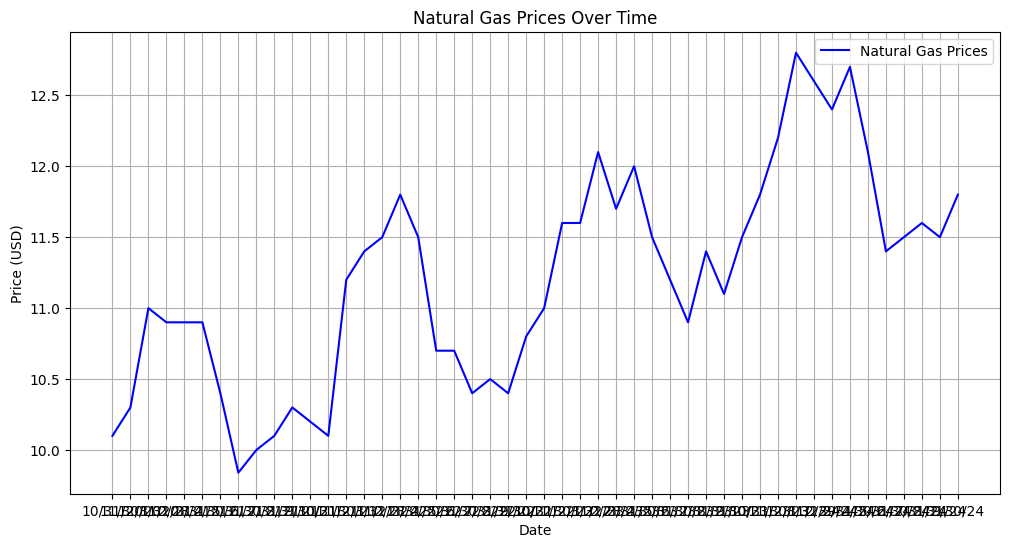

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(time, price, label='Natural Gas Prices', color='blue')
plt.title('Natural Gas Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

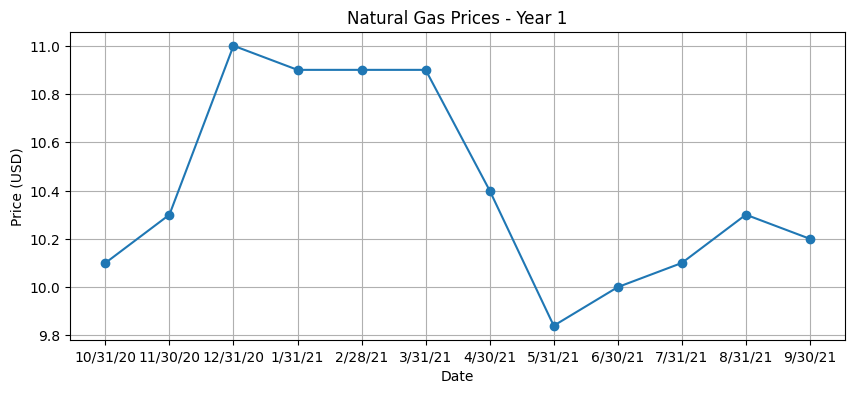

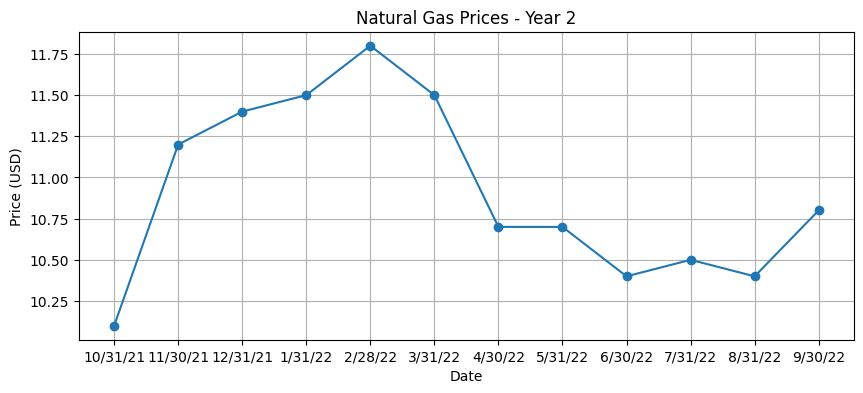

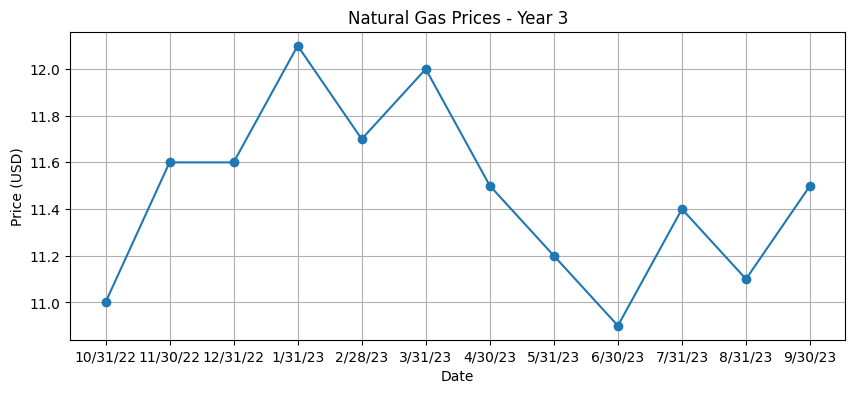

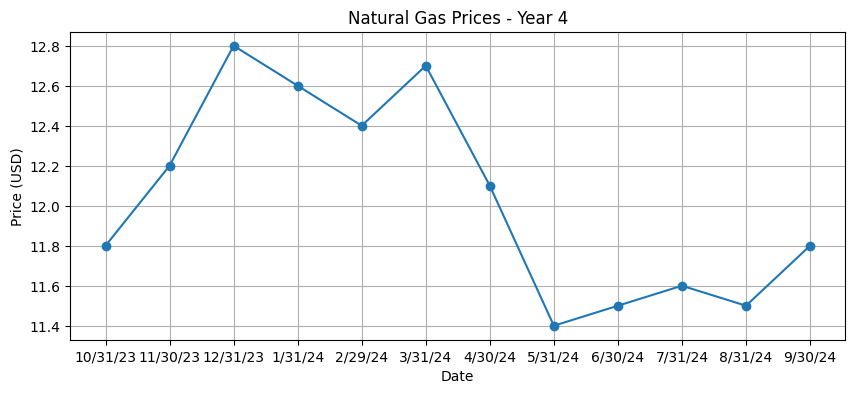

In [6]:
for i in range(4):
    dates_year = nat_gas_data['Dates'][12*i:12*(i+1)]
    prices_year = nat_gas_data['Prices'][12*i:12*(i+1)]
    plt.figure(figsize=(10, 4))
    plt.plot(dates_year, prices_year, marker='o')
    plt.title(f'Natural Gas Prices - Year {i+1}')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.grid()
    plt.show()

We can make the assumption that for a given year, the prices follow the same pattern

We are gonna use FFT to find the signal because it seems to be periodic

# FFT

Text(0.5, 0, 'Frequency (1/months)')

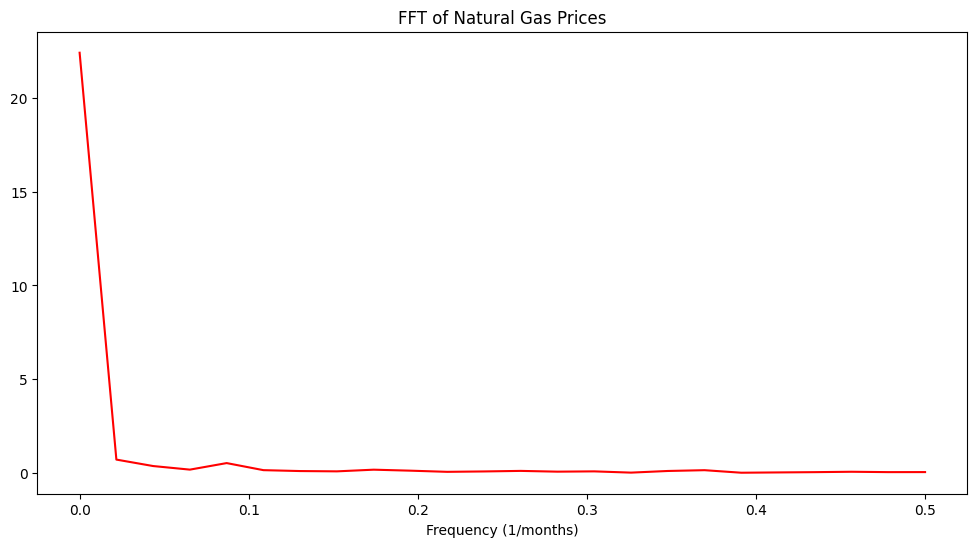

In [7]:
N = nat_gas_data.shape[0]
T = 1.0

yf = scipy.fftpack.fft(nat_gas_data['Prices'].values)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure(figsize=(12, 6))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), color='red')
plt.title('FFT of Natural Gas Prices')
plt.xlabel('Frequency (1/months)')

Let's do some harmonic regression

Intercept: -19625501737207.67
Coefficients for harmonics:
Frequency 0.0000: sin=-2504193834093.4282, cos=247245439240.3937
Frequency 0.0217: sin=-0.7269, cos=0.0351
Frequency 0.0870: sin=0.4414, cos=-0.4962
Frequency 0.0435: sin=-0.4052, cos=-0.1165
Frequency 0.0652: sin=-0.3319, cos=-0.0156
Frequency 0.1739: sin=0.0636, cos=0.0109
Frequency 0.1087: sin=-0.0945, cos=-0.1913
Frequency 0.3696: sin=-0.1042, cos=-0.1240
Frequency 0.1957: sin=-0.0045, cos=0.2172
Frequency 0.2609: sin=-0.0247, cos=0.2518
Frequency 0.3478: sin=-0.1037, cos=0.0664
Frequency 0.1304: sin=0.2566, cos=-0.2883
Frequency 0.1522: sin=0.2576, cos=-0.0117
Frequency 0.3043: sin=-0.1116, cos=-0.0038
Frequency 0.2391: sin=0.0138, cos=-0.0899
Frequency 0.2826: sin=-0.1598, cos=-0.0317
Frequency 0.4565: sin=-0.1795, cos=-0.0548
Frequency 0.2174: sin=0.0509, cos=0.1397
Frequency 0.5000: sin=-132208927636890.8594, cos=-0.5190
Frequency 0.4783: sin=-0.2963, cos=0.0211
Frequency 0.4348: sin=-0.1773, cos=-0.0381
Frequency 0.4130

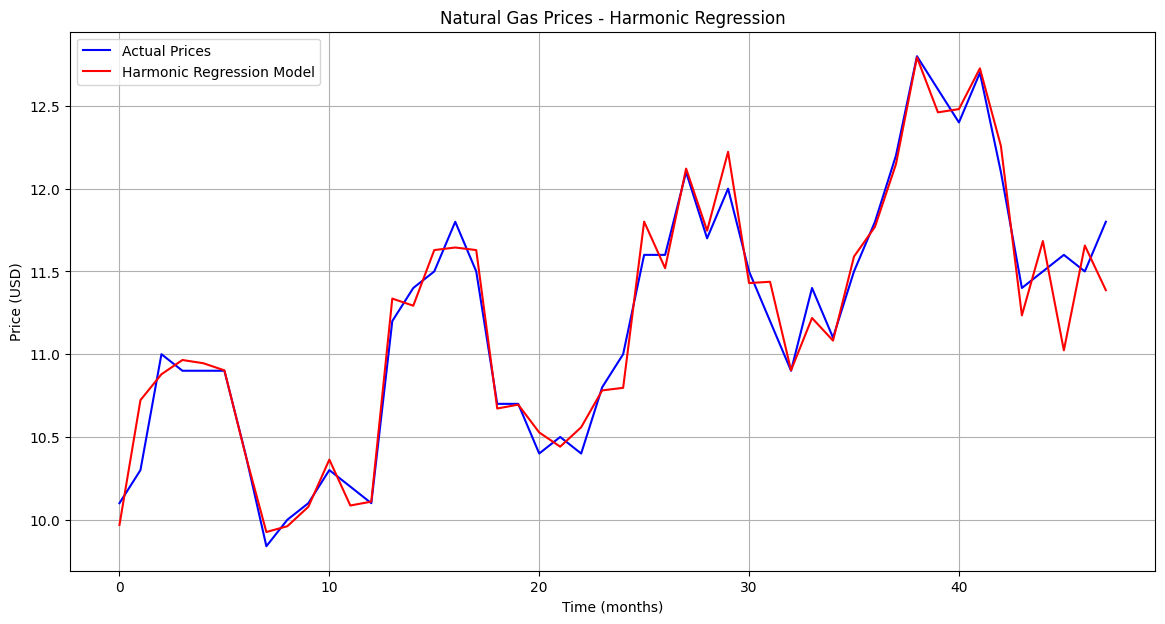

In [8]:
from sklearn.linear_model import LinearRegression

# Create time index for regression
t = np.arange(len(nat_gas_data))

# Identify dominant frequencies from FFT
sorted_indices = np.argsort(np.abs(yf[:N//2]))[::-1][0:100]  # Exclude the zero frequency
dominant_freqs = xf[sorted_indices]

# Prepare features for harmonic regression
X = np.ones((len(t), 1 + 2*len(dominant_freqs)))  # Intercept + sin/cos terms
X[:, 0] = 1  # Intercept term

# Add sine and cosine terms for each dominant frequency
for i, freq in enumerate(dominant_freqs):
    X[:, 2*i+1] = np.sin(2 * np.pi * freq * t)
    X[:, 2*i+2] = np.cos(2 * np.pi * freq * t)

# Fit regression model
model = LinearRegression()
model.fit(X, price)

# Predict using the model
price_pred = model.predict(X)

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(t, price, 'b-', label='Actual Prices')
plt.plot(t, price_pred, 'r-', label='Harmonic Regression Model')
plt.title('Natural Gas Prices - Harmonic Regression')
plt.xlabel('Time (months)')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)

# Print model coefficients
print("Intercept:", model.intercept_)
print("Coefficients for harmonics:")
for i, freq in enumerate(dominant_freqs):
    print(f"Frequency {freq:.4f}: sin={model.coef_[2*i+1]:.4f}, cos={model.coef_[2*i+2]:.4f}")

# Calculate model performance
r2 = model.score(X, price)
rmse = np.sqrt(np.mean((price - price_pred)**2))
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

In [9]:
# Create time index for regression
t = np.arange(len(nat_gas_data))

In [10]:
a = np.polyfit(t, nat_gas_data['Prices'], 1)

In [11]:
drift = a[0] * t + a[1]

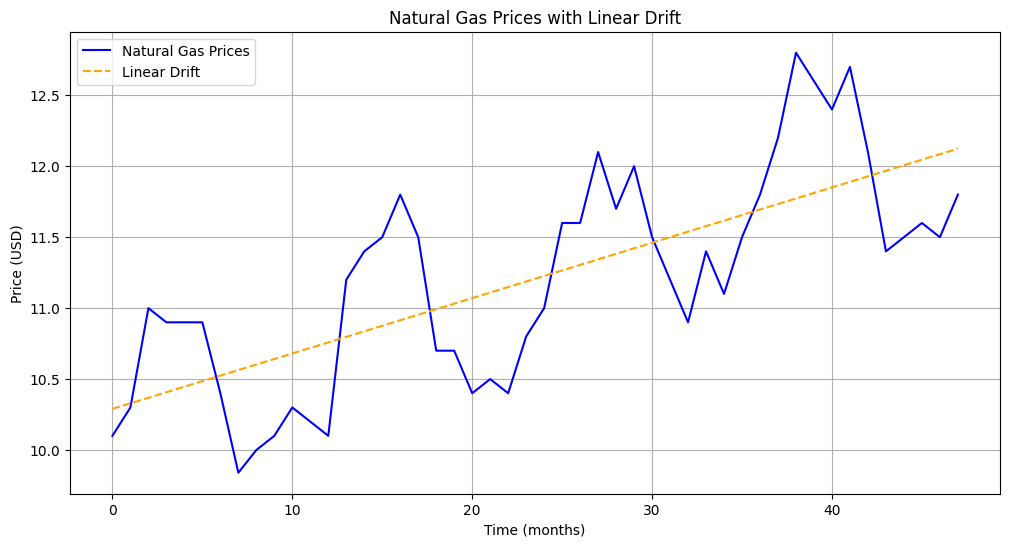

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(t, nat_gas_data['Prices'], label='Natural Gas Prices', color='blue')
plt.plot(t, drift, label='Linear Drift', color='orange', linestyle='--')
plt.title('Natural Gas Prices with Linear Drift')
plt.xlabel('Time (months)')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)

In [13]:
y = nat_gas_data['Prices'] - drift

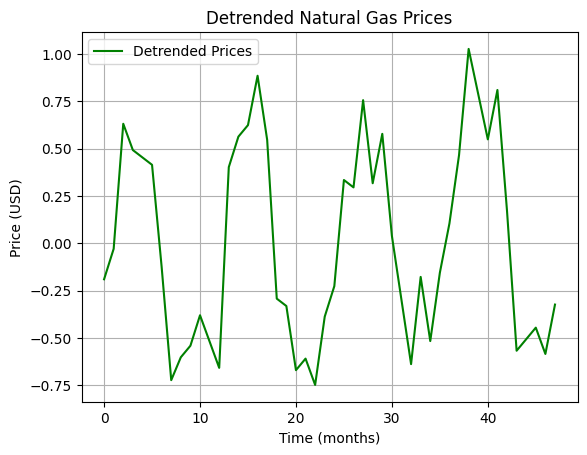

In [14]:
plt.plot(t, y, label='Detrended Prices', color='green')
plt.title('Detrended Natural Gas Prices')
plt.xlabel('Time (months)')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)

We will perfom an fft on this signal. We will consider the drift is constant

Text(0.5, 1.0, 'FFT of Detrended Natural Gas Prices')

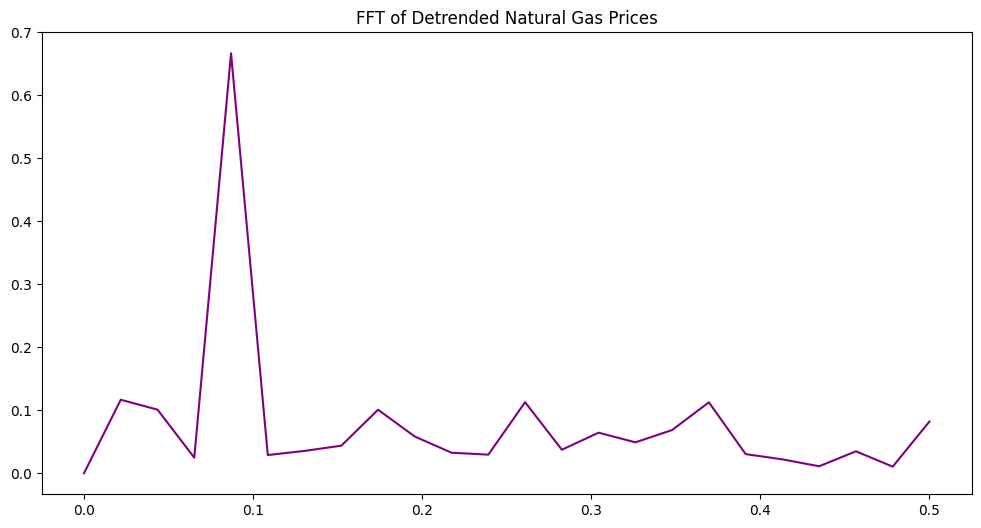

In [15]:
yf = np.fft.fft(y)
T = 1.0
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

plt.figure(figsize=(12, 6))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), color='purple')
plt.title('FFT of Detrended Natural Gas Prices')

let's find the coefficients

In [16]:
amps = 2.0/N * np.abs(yf[:N//2])   # amplitudes

In [17]:
for f, a in zip(xf, amps):
    if a > 0.1:  # filter small ones
        print(f"f={f:.4f} Hz, amplitude≈{a:.2f}")

f=0.0217 Hz, amplitude≈0.12
f=0.0435 Hz, amplitude≈0.10
f=0.0870 Hz, amplitude≈0.67
f=0.1739 Hz, amplitude≈0.10
f=0.2609 Hz, amplitude≈0.11
f=0.3696 Hz, amplitude≈0.11


In [70]:
# Identify dominant frequencies from FFT
sorted_indices = np.argsort(np.abs(yf[:N//2]))[::-1][0:6]
dominant_freqs = xf[sorted_indices]

Intercept: 0.012263256524589632
Coefficients for harmonics:
Frequency 0.0870: amplitude=0.6526, phase=-0.5887
Frequency 0.0217: amplitude=0.1354, phase=2.7752
Frequency 0.2609: amplitude=0.0747, phase=-2.0768
Frequency 0.3696: amplitude=0.0757, phase=1.4924
Frequency 0.0435: amplitude=0.1190, phase=-2.8116
Frequency 0.1739: amplitude=0.0680, phase=-2.5931
R² Score: 0.8545
RMSE: 0.1983


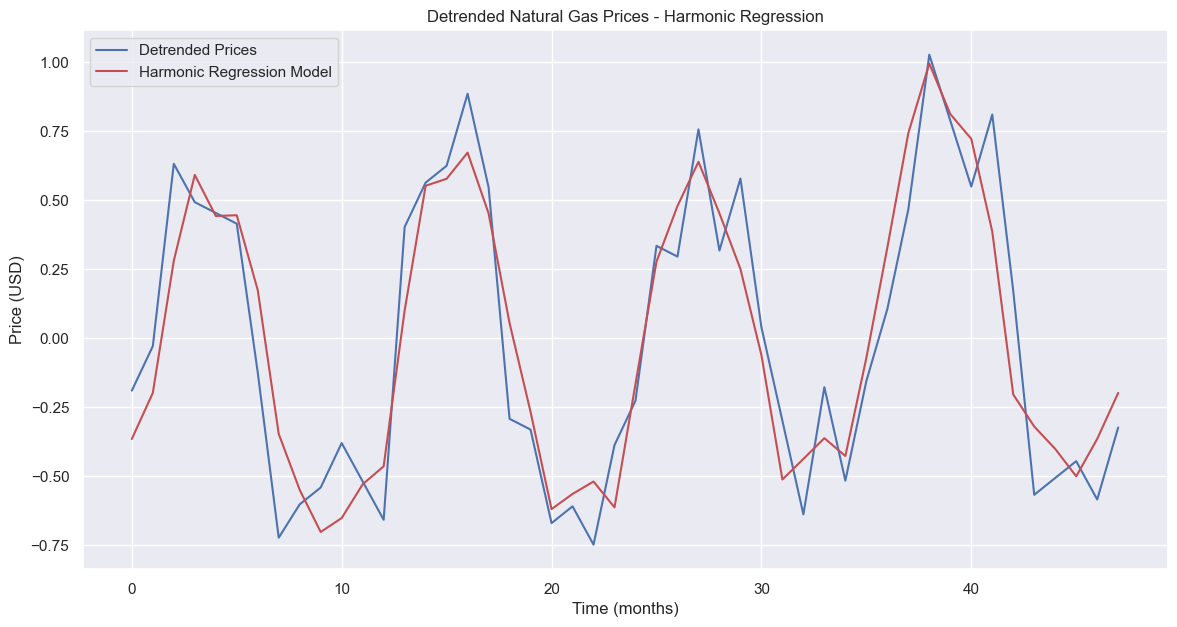

In [71]:
# Create a new model for the detrended data using dominant frequencies
X_detrended = np.ones((len(t), 1 + 2*len(dominant_freqs)))  # Intercept + sin/cos terms
X_detrended[:, 0] = 1  # Intercept term

# Add sine and cosine terms for each dominant frequency
for i, freq in enumerate(dominant_freqs):
    X_detrended[:, 2*i+1] = np.sin(2 * np.pi * freq * t)
    X_detrended[:, 2*i+2] = np.cos(2 * np.pi * freq * t)

# Fit regression model on detrended data
model_detrended = LinearRegression()
model_detrended.fit(X_detrended, y)

# Predict using the model
y_pred = model_detrended.predict(X_detrended)

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(t, y, 'b-', label='Detrended Prices')
plt.plot(t, y_pred, 'r-', label='Harmonic Regression Model')
plt.title('Detrended Natural Gas Prices - Harmonic Regression')
plt.xlabel('Time (months)')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)

# Print model coefficients
print("Intercept:", model_detrended.intercept_)
print("Coefficients for harmonics:")
for i, freq in enumerate(dominant_freqs):
    amplitude = np.sqrt(model_detrended.coef_[2*i+1]**2 + model_detrended.coef_[2*i+2]**2)
    phase = np.arctan2(model_detrended.coef_[2*i+2], model_detrended.coef_[2*i+1])
    print(f"Frequency {freq:.4f}: amplitude={amplitude:.4f}, phase={phase:.4f}")

# Calculate model performance metrics
r2_detrended = model_detrended.score(X_detrended, y)
rmse_detrended = np.sqrt(np.mean((y - y_pred)**2))
print(f"R² Score: {r2_detrended:.4f}")
print(f"RMSE: {rmse_detrended:.4f}")

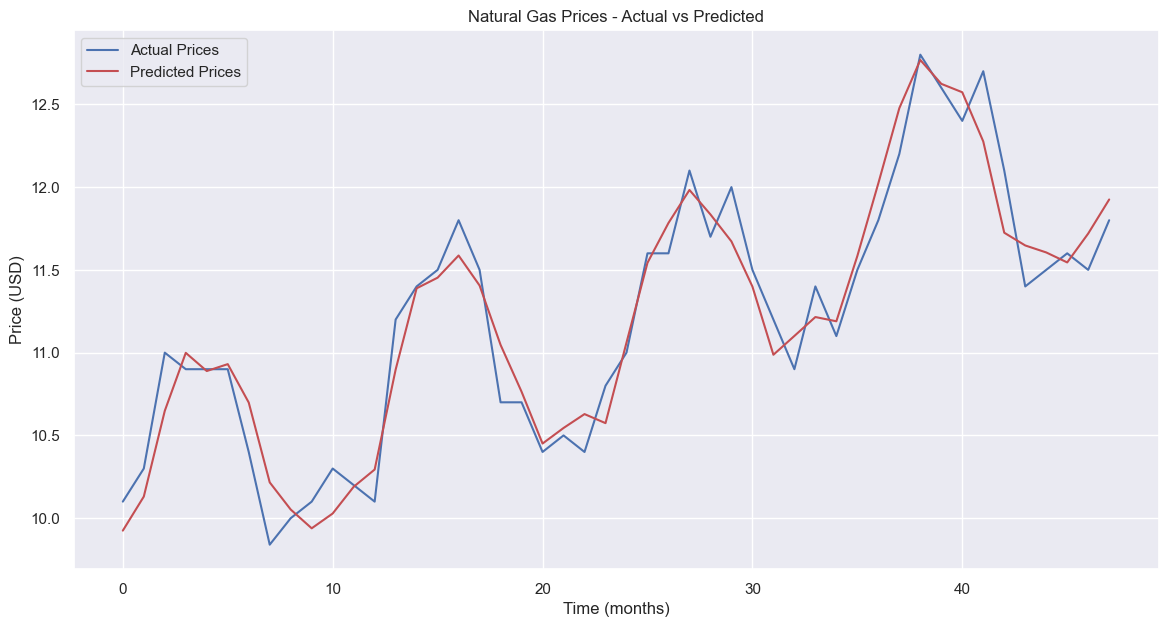

In [72]:
price_pred = y_pred + drift

plt.figure(figsize=(14, 7))
plt.plot(t, price, 'b-', label='Actual Prices')
plt.plot(t, price_pred, 'r-', label='Predicted Prices')
plt.title('Natural Gas Prices - Actual vs Predicted')
plt.xlabel('Time (months)')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [73]:
a = np.polyfit(t, nat_gas_data['Prices'], 1)

In [74]:
future_t = np.arange(len(t), len(t) + 12)  # Predict next 12 months

future_drift = a[0] * future_t + a[1]

X_future = np.ones((len(future_t), 1 + 2*len(dominant_freqs)))
for i, f in enumerate(dominant_freqs):
    X_future[:, 2*i+1] = np.sin(2*np.pi*f*future_t)
    X_future[:, 2*i+2] = np.cos(2*np.pi*f*future_t)
    
y_future = model_detrended.predict(X_future)
price_future = y_future + future_drift

In [75]:
total_t = np.concatenate([t, future_t])

In [76]:
total_future_price = np.concatenate([price_pred, price_future])

In [77]:
sns.set_theme(style="darkgrid")

c:\Users\josse\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\josse\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\josse\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\josse\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

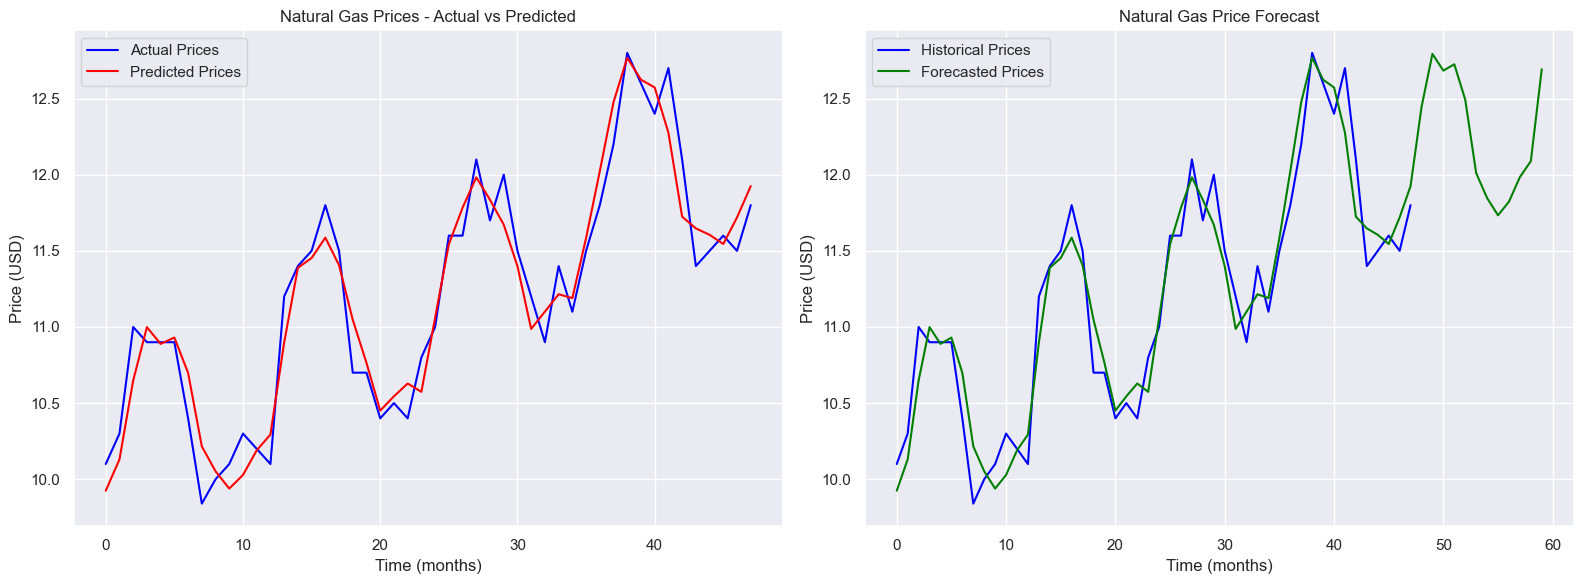

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.lineplot(x=t, y=price, label='Actual Prices', ax=axes[0], color='blue')
sns.lineplot(x=t, y=price_pred, label='Predicted Prices', ax=axes[0], color='red')
axes[0].set_title('Natural Gas Prices - Actual vs Predicted')
axes[0].set_xlabel('Time (months)')
axes[0].set_ylabel('Price (USD)')

sns.lineplot(x=t, y=price, label='Historical Prices', ax=axes[1], color='blue')
sns.lineplot(x=total_t, y=total_future_price, label='Forecasted Prices', ax=axes[1], color='green')
axes[1].set_title('Natural Gas Price Forecast')
axes[1].set_xlabel('Time (months)')
axes[1].set_ylabel('Price (USD)')

plt.tight_layout()
plt.show()

In [ ]:
def predict_future(date):
    # Convert date to time index
    date_index = (pd.to_datetime(date) - pd.to_datetime(nat_gas_data['Dates'].iloc[0])).days // 30
    if date_index < len(t):
        return price_pred[date_index]
    else:
        future_index = date_index - len(t)
        future_drift_value = a[0] * (len(t) + future_index) + a[1]
        X_future_value = np.ones((1, 1 + 2*len(dominant_freqs)))
        X_future_value[0, 0] = 1
        for i, f in enumerate(dominant_freqs):
            X_future_value[0, 2*i+1] = np.sin(2*np.pi*f*(len(t) + future_index))
            X_future_value[0, 2*i+2] = np.cos(2*np.pi*f*(len(t) + future_index))
        y_future_value = model_detrended.predict(X_future_value)
        return y_future_value[0] + future_drift_value